In [1]:
%matplotlib inline

import os
import time
import math
import glob
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
from torch.nn import functional as F

from models import unet

DEVICE = "cuda:0"
SAVE_PATH = 'weights/unet_ba_4_oo.pt'

# set device
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [2]:
## Creating the dataset

In [3]:
class ForestDataset(torch.utils.data.Dataset):
    
    '''Characterizes a dataset for PyTorch'''
    
    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['x_ortho']
        self.dsm = self.dset['x_dsm']
        #self.dtm = self.dset['x_dtm']
        #self.slope = self.dset['x_slope']
        self.ground_truth = self.dset['y_ground_truth']
        
        # set number of samples
        self.length = self.ground_truth.shape[0]
        #self.labels = labels
        #self.list_IDs = list_IDs
        
        ## TODO:
        # make means and stds load from hdf5
        self.means_wien = np.array([56.003890684524514, 68.57362613839135, 74.81702698592574, 153.3728899964296], dtype='float32')
        self.stds_wien = np.array([22.921560008757936, 24.69759936552532, 19.553485949030918, 35.00320612463889], dtype='float32')
        
        self.means_mariazell = np.array([52.57864629094064, 63.1731943283136, 59.55804782119867, 101.3607586098534], dtype='float32')
        self.stds_mariazell = np.array([37.73983594430985, 35.156998551108586, 25.451356265963383, 47.10539409662177], dtype='float32')
        

        self.means_dsm = np.array([19.374141483516485]).astype(np.float32)
        self.stds_dsm = np.array([10.730142507812797]).astype(np.float32)
        
        #self.transforms = T.Compose([T.ToTensor()])

    def __len__(self):
        '''Denotes the total number of samples'''
        return self.length

    def __getitem__(self, index):
        '''Generates one sample of data'''
        
        # depending on data change mean and std
        if index < 46868:
            means = self.means_wien
            stds = self.stds_wien
        else:
            means = self.means_mariazell
            stds = self.stds_mariazell
            
        # Load data and get label
        X_ortho = (torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) - \
             means[:, np.newaxis, np.newaxis]) / stds[:, np.newaxis, np.newaxis]
        
        X_dsm = (torch.tensor(self.dsm[index], dtype=torch.float32).permute(2, 0, 1) - self.means_dsm) / self.stds_dsm
        
        #X = np.concatenate([x0, x1, x2, x3], axis=2)
        X = torch.cat((X_ortho, X_dsm),0)
        #X = torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) / 255
        
        y = torch.tensor(self.ground_truth[index][:,:,0], dtype=torch.torch.int64)
        
        #X = torch.from_numpy(np.array(self.ortho[index]).transpose(2,0,1)) / 255
        #y = torch.from_numpy(np.array(self.ground_truth[index])[:,:,0], dtype=torch.torch.int64)

        return X, y #torch.from_numpy(y).permute(2, 0, 1)
        
        
    def show_item(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))
        
        fig = plt.figure(figsize=(20,20))
        
        a = fig.add_subplot(2, 2, 1)
        imgplot = plt.imshow(np.array(self.ortho[index][:,:,:3]))
        a.set_title('RGB')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 2, 2)
        imgplot = plt.imshow(np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]))
        a.set_title('CIR')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 2, 3)
        imgplot = plt.imshow(np.array(self.dsm[index].astype('f')))
        imgplot.set_clim(0.0, 40.0)
        a.set_title('Tree Height')
        plt.colorbar(ticks=[10, 20, 30], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(2, 2, 4)
        imgplot = plt.imshow(np.array(self.ground_truth[index]), cmap="hot")
        imgplot.set_clim(0, 5)
        a.set_title('Ground Truth')
        plt.colorbar(ticks=[0, 1, 2, 3, 4], orientation='horizontal')
        plt.axis('off')
        
        
    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()

In [4]:
path_dataset = "/home/philipp/Data/dataset/dataset_256_ba_dsm.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_256_ba_dsm.h5"
data = ForestDataset(path_dataset)
len(data)

91000

In [5]:
X, y = data[1000]
X.shape, y.shape

(torch.Size([5, 256, 256]), torch.Size([256, 256]))

In [6]:
y[0].shape

torch.Size([256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


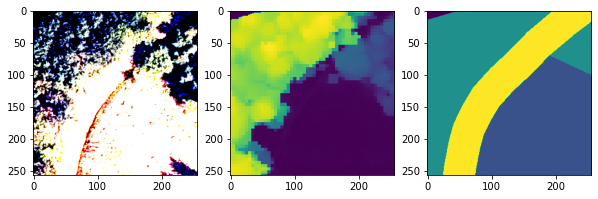

In [7]:
X, y = data[51]
fig, ax = plt.subplots(1,3, figsize=(10,9))
ax[0].imshow(X.permute(1, 2, 0).numpy()[:,:,:3])
ax[1].imshow(X.permute(1, 2, 0).numpy()[:,:,4])
ax[2].imshow(y.numpy())

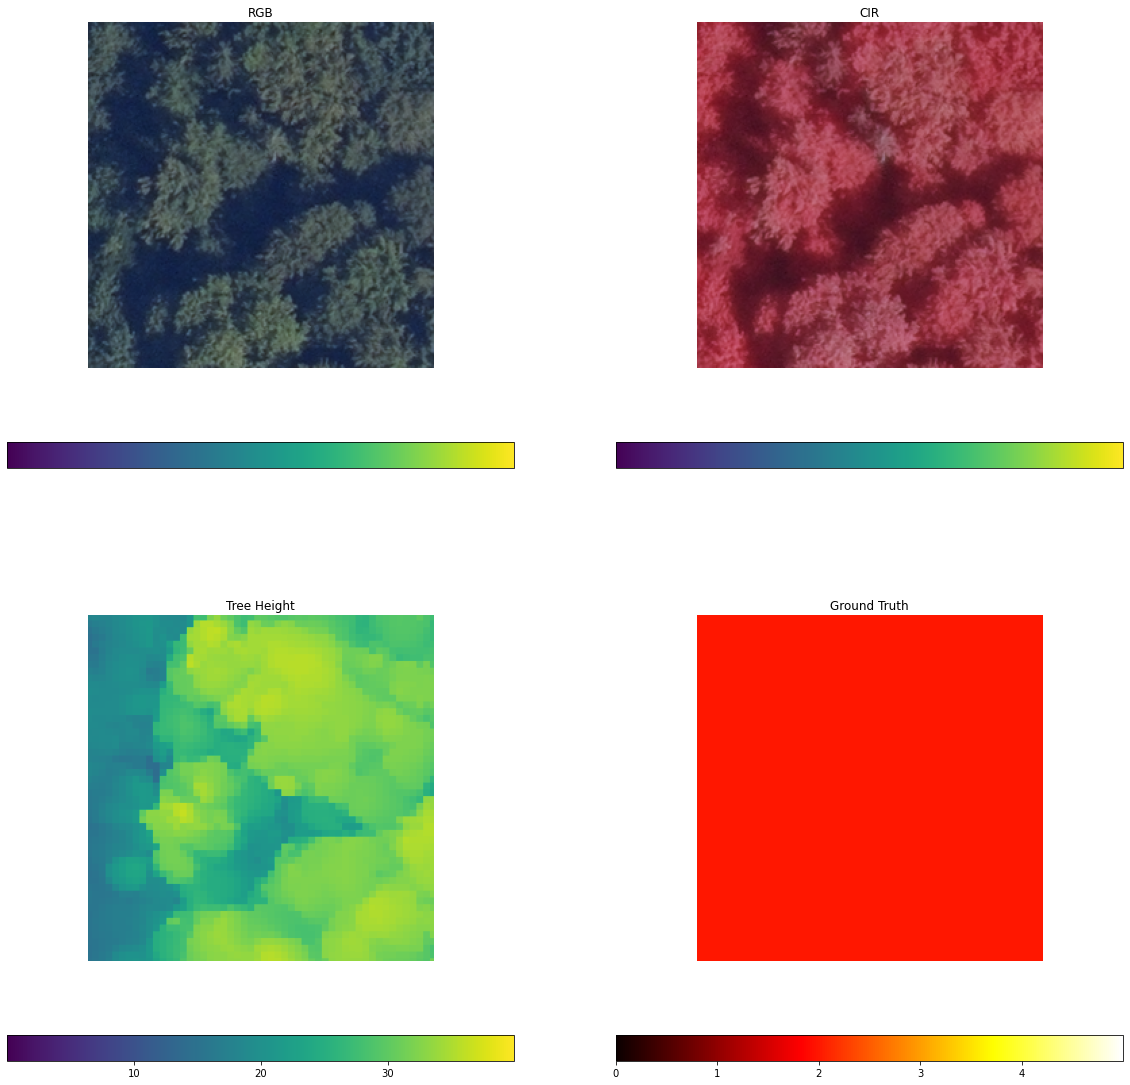

In [8]:
data.show_item(81)

In [9]:
# split data

In [10]:
batch_size = 32
validation_split = .4
test_split = .4
shuffle_dataset = True
random_seed = 15

# Creating data indices for training and validation splits:
dataset_size = 91000
#dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

18200
36400
36400


In [11]:
# Creating PT data samplers and loaders:
train_sampler = sampler.SubsetRandomSampler(train_indices)
valid_sampler = sampler.SubsetRandomSampler(val_indices)

train_dl = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4, pin_memory=True)

In [12]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([32, 5, 256, 256]), torch.Size([32, 256, 256]))

In [13]:
## Unet

In [14]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 64, 3, 1)
        self.conv2 = self.contract_block(64, 128, 3, 1)
        self.conv3 = self.contract_block(128, 256, 3, 1)
        self.conv4 = self.contract_block(256, 512, 3, 1)
        
        self.upconv4 = self.expand_block(512, 256, 3, 1)
        self.upconv3 = self.expand_block(256*2, 128, 3, 1)
        self.upconv2 = self.expand_block(128*2, 64, 3, 1)
        self.upconv1 = self.expand_block(64*2, out_channels, 3, 1)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        
        out = self.softmax(upconv1)

        return out

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [15]:
# input 4 channels, output 2 classes
unet = UNET(5,5)

# try to load model
try:
    #unet = torch.load(Path('model/unet_typ.pkl'))
    unet.load_state_dict(torch.load(SAVE_PATH))
    unet.to(device)
except:
    pass

In [16]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([32, 5, 256, 256]), torch.Size([32, 256, 256]))

In [18]:

#pred = unet(xb)
#pred.shape

In [18]:
outputs = unet(xb)

In [19]:
outputs.shape

torch.Size([32, 5, 256, 256])

In [20]:
logits = outputs

In [21]:
num_classes = logits.shape[1]

In [22]:
num_classes

5

In [23]:
yb.squeeze(1).shape

torch.Size([32, 256, 256])

In [24]:
yb.shape

torch.Size([32, 256, 256])

In [25]:
true_1_hot = torch.eye(num_classes)

In [26]:
true_1_hot

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

In [27]:
yb.squeeze(1).shape

torch.Size([32, 256, 256])

In [28]:
yb.shape

torch.Size([32, 256, 256])

In [29]:
true_1_hot[yb]

tensor([[[[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          ...,
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]],

         [[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          ...,
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]],

         [[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          ...,
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]],

         ...,

         [[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          ...,
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.]],

         [[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          ...,
          [0., 0., 1., 0., 0.],
      

In [31]:
true_1_hot = torch.eye(num_classes)[yb.squeeze(1).long()]

In [32]:
true_1_hot.shape

torch.Size([32, 256, 256, 5])

In [33]:
true_1_hot = true_1_hot.permute(0, 3, 1, 2).float().contiguous()

In [34]:
true_1_hot.shape

torch.Size([32, 5, 256, 256])

In [35]:
true_1_hot.dtype

torch.float32

In [173]:
probas = F.softmax(logits, dim=1)

In [174]:
probas.shape

torch.Size([32, 5, 256, 256])

In [175]:
true_1_hot = true_1_hot.type(logits.type())

In [176]:
true_1_hot.dtype

torch.float32

In [178]:
dims = (0,) + tuple(range(2, yb.ndimension()+1))

In [152]:
dims = (2,3)

In [179]:
dims

(0, 2, 3)

In [180]:
print(probas.shape)
print(true_1_hot.shape)

torch.Size([32, 5, 256, 256])
torch.Size([32, 5, 256, 256])


In [181]:
intersection = torch.sum(probas * true_1_hot, dims)

In [182]:
print(probas.dtype)
print(true_1_hot.dtype)

torch.float32
torch.float32


In [183]:
intersection.shape

torch.Size([5])

In [184]:
intersection = torch.sum(probas * true_1_hot, dims)
intersection.shape

torch.Size([5])

In [185]:
cardinality = torch.sum(probas + true_1_hot, dims)
cardinality.shape

torch.Size([5])

In [186]:
union = cardinality - intersection
union.shape

torch.Size([5])

In [187]:
union

tensor([ 399020.5938,  528133.4375, 1192267.3750, 1172323.2500,  447276.6875],
       grad_fn=<SubBackward0>)

In [188]:
jacc_loss = (intersection / (union + 1e-7)).mean()

In [189]:
# dim (2,3)
jacc_loss

tensor(0.0887, grad_fn=<MeanBackward0>)

In [136]:
# dim (0,2)
jacc_loss

tensor(0.0883, grad_fn=<MeanBackward0>)

In [111]:
# dim (0)
jacc_loss

tensor(0.0873, grad_fn=<MeanBackward0>)

In [17]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [19]:
# IoU loss

def jaccard_loss(true, logits, eps=1e-7):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the jaccard loss so we
    return the negated jaccard loss.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        jacc_loss: the Jaccard loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float().contiguous()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float().contiguous()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()+1))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    union = cardinality - intersection
    jacc_loss = (intersection / (union + eps)).mean()
    return (1 - jacc_loss)

In [17]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, logits, true, eps=1e-7):
        """Computes the Jaccard loss, a.k.a the IoU loss.
        Note that PyTorch optimizers minimize a loss. In this
        case, we would like to maximize the jaccard loss so we
        return the negated jaccard loss.
        Args:
            true: a tensor of shape [B, H, W] or [B, 1, H, W].
            logits: a tensor of shape [B, C, H, W]. Corresponds to
                the raw output or logits of the model.
            eps: added to the denominator for numerical stability.
        Returns:
            jacc_loss: the Jaccard loss.
        """
        #print(true.shape)
        #print(logits.shape)
        
        num_classes = logits.shape[1]
        if num_classes == 1:
            true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float().contiguous()
            true_1_hot_f = true_1_hot[:, 0:1, :, :]
            true_1_hot_s = true_1_hot[:, 1:2, :, :]
            true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
            pos_prob = torch.sigmoid(logits)
            neg_prob = 1 - pos_prob
            probas = torch.cat([pos_prob, neg_prob], dim=1)
        else:
            true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
            #print(true_1_hot.shape)
            true_1_hot = true_1_hot.permute(0, 3, 1, 2).float().contiguous()
            probas = F.softmax(logits, dim=1)
        #true_1_hot = true_1_hot.type(logits.type())
        dims = (0,) + tuple(range(2, true.ndimension()+1))
        intersection = torch.sum(probas * true_1_hot, dims)
        cardinality = torch.sum(probas + true_1_hot, dims)
        union = cardinality - intersection
        jacc_loss = (intersection / (union + eps)).mean()
        return (1 - jacc_loss)

In [17]:
# https://discuss.pytorch.org/t/one-hot-encoding-with-autograd-dice-loss/9781/4

class Dice_loss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice_loss, self).__init__()

    def forward(self, output, target, eps=1e-7, ignore_index=None, weights=None):
        """
        output : NxCxHxW Variable
        target :  NxHxW LongTensor
        weights : C FloatTensor
        ignore_index : int index to ignore from loss
        """

        output = output.exp()
        encoded_target = output.detach() * 0
        if ignore_index is not None:
            mask = target == ignore_index
            target = target.clone()
            target[mask] = 0
            encoded_target.scatter_(1, target.unsqueeze(1), 1)
            mask = mask.unsqueeze(1).expand_as(encoded_target)
            encoded_target[mask] = 0
        else:
            encoded_target.scatter_(1, target.unsqueeze(1), 1)

        if weights is None:
            weights = 1

        intersection = output * encoded_target
        numerator = 2 * intersection.sum(0).sum(1).sum(1)
        denominator = output + encoded_target

        if ignore_index is not None:
            denominator[mask] = 0
        denominator = denominator.sum(0).sum(1).sum(1) + eps
        loss_per_channel = weights * (1 - (numerator / denominator))

        return loss_per_channel.sum() / output.size(1)


In [18]:
def ce_loss(true, logits, weights, ignore=255):
    """Computes the weighted multi-class cross-entropy loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        weight: a tensor of shape [C,]. The weights attributed
            to each class.
        ignore: the class index to ignore.
    Returns:
        ce_loss: the weighted multi-class cross-entropy loss.
    """
    ce_loss = F.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss

In [19]:
# error metrics

EPS = 1e-10


def _fast_hist(true, pred, num_classes):
    true = true.cpu()
    pred = pred.cpu()
    mask = ((true >= 0) & (true < num_classes)).to(device)
    hist = torch.bincount(
        num_classes * true[mask] + pred[mask],
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist


def overall_pixel_accuracy(hist):
    """Computes the total pixel accuracy.
    The overall pixel accuracy provides an intuitive
    approximation for the qualitative perception of the
    label when it is viewed in its overall shape but not
    its details.
    Args:
        hist: confusion matrix.
    Returns:
        overall_acc: the overall pixel accuracy.
    """
    correct = torch.diag(hist).sum()
    total = hist.sum()
    overall_acc = correct / (total + EPS)
    return overall_acc


def per_class_pixel_accuracy(hist):
    """Computes the average per-class pixel accuracy.
    The per-class pixel accuracy is a more fine-grained
    version of the overall pixel accuracy. A model could
    score a relatively high overall pixel accuracy by
    correctly predicting the dominant labels or areas
    in the image whilst incorrectly predicting the
    possibly more important/rare labels. Such a model
    will score a low per-class pixel accuracy.
    Args:
        hist: confusion matrix.
    Returns:
        avg_per_class_acc: the average per-class pixel accuracy.
    """
    correct_per_class = torch.diag(hist)
    total_per_class = hist.sum(dim=1)
    per_class_acc = correct_per_class / (total_per_class + EPS)
    avg_per_class_acc = nanmean(per_class_acc)
    return avg_per_class_acc


def jaccard_index(hist):
    """Computes the Jaccard index, a.k.a the Intersection over Union (IoU).
    Args:
        hist: confusion matrix.
    Returns:
        avg_jacc: the average per-class jaccard index.
    """
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    jaccard = A_inter_B / (A + B - A_inter_B + EPS)
    avg_jacc = nanmean(jaccard)
    return avg_jacc


def dice_coefficient(hist):
    """Computes the Sørensen–Dice coefficient, a.k.a the F1 score.
    Args:
        hist: confusion matrix.
    Returns:
        avg_dice: the average per-class dice coefficient.
    """
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    dice = (2 * A_inter_B) / (A + B + EPS)
    avg_dice = nanmean(dice)
    return avg_dice


def eval_metrics(true, pred, num_classes):
    """Computes various segmentation metrics on 2D feature maps.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        pred: a tensor of shape [B, H, W] or [B, 1, H, W].
        num_classes: the number of classes to segment. This number
            should be less than the ID of the ignored class.
    Returns:
        overall_acc: the overall pixel accuracy.
        avg_per_class_acc: the average per-class pixel accuracy.
        avg_jacc: the jaccard index.
        avg_dice: the dice coefficient.
    """
    hist = torch.zeros((num_classes, num_classes))
    for t, p in zip(true, pred):
        hist += _fast_hist(t.flatten(), p.flatten(), num_classes)
    overall_acc = overall_pixel_accuracy(hist)
    avg_per_class_acc = per_class_pixel_accuracy(hist)
    avg_jacc = jaccard_index(hist)
    avg_dice = dice_coefficient(hist)
    return overall_acc, avg_per_class_acc, avg_jacc, avg_dice

def nanmean(x):
    """Computes the arithmetic mean ignoring any NaNs."""
    return torch.mean(x[x == x])


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
def get_predictions(output_batch):
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs,h,w)
    return indices

In [21]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    # Reduce learning rate when a metric has stopped improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)
    
    start = time.time()
    model.to(device)

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0
            running_acc_all = 0.0
            running_acc_mean = 0.0
            running_jacc = 0.0
            running_dice = 0.0
            nr_exp = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.to(device)
                y = y.to(device)
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = jaccard_loss(y, outputs)
                    #loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        #loss = jaccard_loss(y.long(), outputs)
                        loss = loss_fn(outputs, y.long())
                        
                pred = get_predictions(outputs)

                # stats - whatever is the phase
                #overall_acc, avg_per_class_acc, avg_jacc, avg_dice = eval_metrics(y, pred, num_classes=5)
                acc = acc_fn(outputs, y)

                running_loss += loss*dataloader.batch_size
                running_acc += acc*dataloader.batch_size
                #running_acc_all += overall_acc*dataloader.batch_size
                #running_acc_mean += avg_per_class_acc*dataloader.batch_size
                #running_jacc += avg_jacc*dataloader.batch_size
                #running_dice  += avg_dice*dataloader.batch_size
                #nr_exp += dataloader.batch_size

                if step % 100 == 0:
                    # clear_output(wait=True)

                    print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                          .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
                    # print(torch.cuda.memory_summary())
                    
            if phase == 'train':
                data_size = len(train_indices)
            else:
                data_size = len(val_indices)
                
            epoch_loss = running_loss / data_size
            epoch_acc_all = running_acc / data_size
            #epoch_acc_mean = running_acc_mean / data_size
            #epoch_jacc = running_jacc / data_size
            #epoch_dice = running_dice / data_size

            #clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f}  Acc all: {:.4f}'.format(phase, epoch_loss, epoch_acc_all))
            #print('{} Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
            #      .format(phase, epoch_loss, epoch_acc_all, epoch_acc_mean, epoch_jacc, epoch_dice))
            print('-' * 10)
            
            # save model
            torch.save(unet.state_dict(), SAVE_PATH)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.to(device)).float().mean()

In [22]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.to(device)

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train']:#, 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0
            running_acc_all = 0.0
            running_acc_mean = 0.0
            running_jacc = 0.0
            running_dice = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.to(device)
                y = y.to(device)
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())
                        
                pred = get_predictions(outputs)
                
                # stats - whatever is the phase
                overall_acc, avg_per_class_acc, avg_jacc, avg_dice = eval_metrics(y, pred, num_classes=5)
                acc = acc_fn(outputs, y)

                running_loss += loss*dataloader.batch_size
                running_acc += acc*dataloader.batch_size
                running_acc_all += overall_acc*dataloader.batch_size
                running_acc_mean += avg_per_class_acc*dataloader.batch_size
                running_jacc += avg_jacc*dataloader.batch_size
                running_dice  += avg_dice*dataloader.batch_size

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                          .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
                    
            if phase == 'train':
                data_size = len(train_indices)
            else:
                data_size = len(val_indices)
                
            epoch_loss = running_loss / data_size
            epoch_acc = running_acc / data_size
            epoch_acc_mean = running_acc_mean / data_size
            epoch_jacc = running_jacc / data_size
            epoch_dice = running_dice / data_size

            #clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(phase, epoch_loss, epoch_acc, epoch_acc_mean, epoch_jacc, epoch_dice))
            #print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)
            
            # save model
            torch.save(unet.state_dict(), SAVE_PATH)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.to(device)).float().mean()

In [23]:
# start training
#loss_fn = nn.CrossEntropyLoss()
loss_fn = Dice_loss()
opt = torch.optim.Adam(unet.parameters(), lr=0.1)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=5)

Epoch 0/4
----------
Step: 100  Loss: 0.5024  Acc all: 0.7411  Acc mean: 0.4962  IoU: 0.3900  Dice: 0.4979
Step: 200  Loss: 0.4985  Acc all: 0.7242  Acc mean: 0.5941  IoU: 0.3857  Dice: 0.5014
Step: 300  Loss: 0.5430  Acc all: 0.5567  Acc mean: 0.5064  IoU: 0.3237  Dice: 0.4570
Step: 400  Loss: 0.4287  Acc all: 0.7803  Acc mean: 0.5473  IoU: 0.4457  Dice: 0.5715
Step: 500  Loss: 0.3375  Acc all: 0.8001  Acc mean: 0.6281  IoU: 0.5317  Dice: 0.6632
Epoch 0/4
----------
train Loss: 0.4646  Acc all: 0.7391  Acc mean: 0.5482  IoU: 0.4198  Dice: 0.5361
----------
Epoch 1/4
----------
Step: 100  Loss: 0.2263  Acc all: 0.8442  Acc mean: 0.7222  IoU: 0.6466  Dice: 0.7737
Step: 200  Loss: 0.3068  Acc all: 0.7560  Acc mean: 0.6534  IoU: 0.5497  Dice: 0.6933
Step: 300  Loss: 0.2498  Acc all: 0.8360  Acc mean: 0.7530  IoU: 0.6201  Dice: 0.7503
Step: 400  Loss: 0.2713  Acc all: 0.8685  Acc mean: 0.6918  IoU: 0.6039  Dice: 0.7287
Step: 500  Loss: 0.4007  Acc all: 0.7309  Acc mean: 0.6088  IoU: 0.4750

In [23]:
# start training
loss_fn = nn.CrossEntropyLoss()
#loss_fn = IoULoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.1)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=5)

Epoch 0/4
----------
RAM memory % used: 7.07
0
RAM memory % used: 7.53
RAM memory % used: 7.54
RAM memory % used: 7.78
RAM memory % used: 7.78
RAM memory % used: 7.78
RAM memory % used: 7.79
RAM memory % used: 7.82
1
RAM memory % used: 7.82
RAM memory % used: 7.82
RAM memory % used: 7.83
RAM memory % used: 7.82
RAM memory % used: 7.82
RAM memory % used: 7.83
RAM memory % used: 7.87
2
RAM memory % used: 7.86
RAM memory % used: 7.87
RAM memory % used: 7.87
RAM memory % used: 7.87
RAM memory % used: 7.87
RAM memory % used: 7.87
RAM memory % used: 7.9
3
RAM memory % used: 7.9
RAM memory % used: 7.94
RAM memory % used: 7.94
RAM memory % used: 7.94
RAM memory % used: 7.94
RAM memory % used: 7.95
RAM memory % used: 7.98
4
RAM memory % used: 7.98
RAM memory % used: 8.02
RAM memory % used: 8.03
RAM memory % used: 8.03
RAM memory % used: 8.03
RAM memory % used: 8.03
RAM memory % used: 8.06
5
RAM memory % used: 8.08
RAM memory % used: 8.11
RAM memory % used: 8.11
RAM memory % used: 8.11
RAM memor

RAM memory % used: 8.18
48
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.17
RAM memory % used: 8.17
RAM memory % used: 8.18
RAM memory % used: 8.18
49
RAM memory % used: 8.18
RAM memory % used: 8.17
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.17
RAM memory % used: 8.17
50
RAM memory % used: 8.17
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.17
RAM memory % used: 8.17
RAM memory % used: 8.17
RAM memory % used: 8.18
51
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.18
RAM memory % used: 8.19
52
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.25
RAM memory % used: 8.19
RAM memory % used: 8.19
53
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.1

RAM memory % used: 8.19
96
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
97
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
98
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
99
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
Step: 100  Loss: 0.9218  Acc all: 0.6307  Acc mean: 0.3142  IoU: 0.2019  Dice: 0.2642
100
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.19
RAM memory % used: 8.2
RAM memory % used: 8.19
101
RAM memory % used: 8.19
RAM mem

KeyboardInterrupt: 

In [ ]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

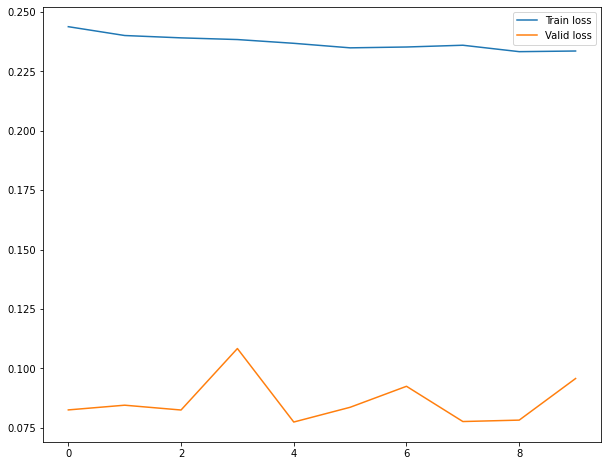

In [18]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

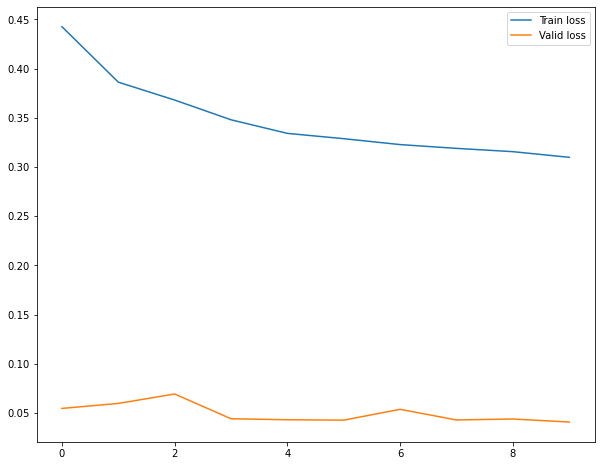

In [18]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

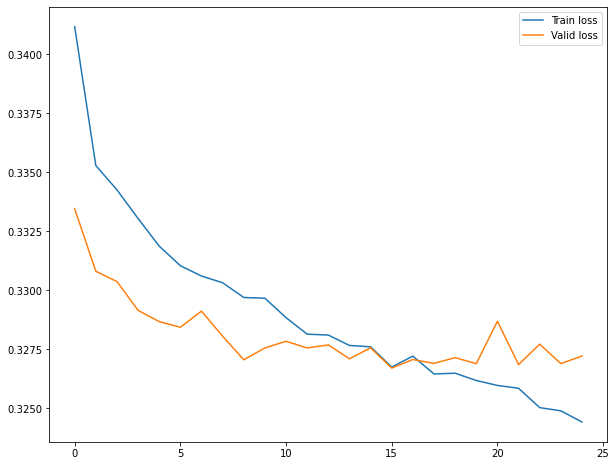

In [37]:
# plot traing loss
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [18]:
# predict

In [31]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [32]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.to(device))

predb.shape

torch.Size([32, 5, 256, 256])

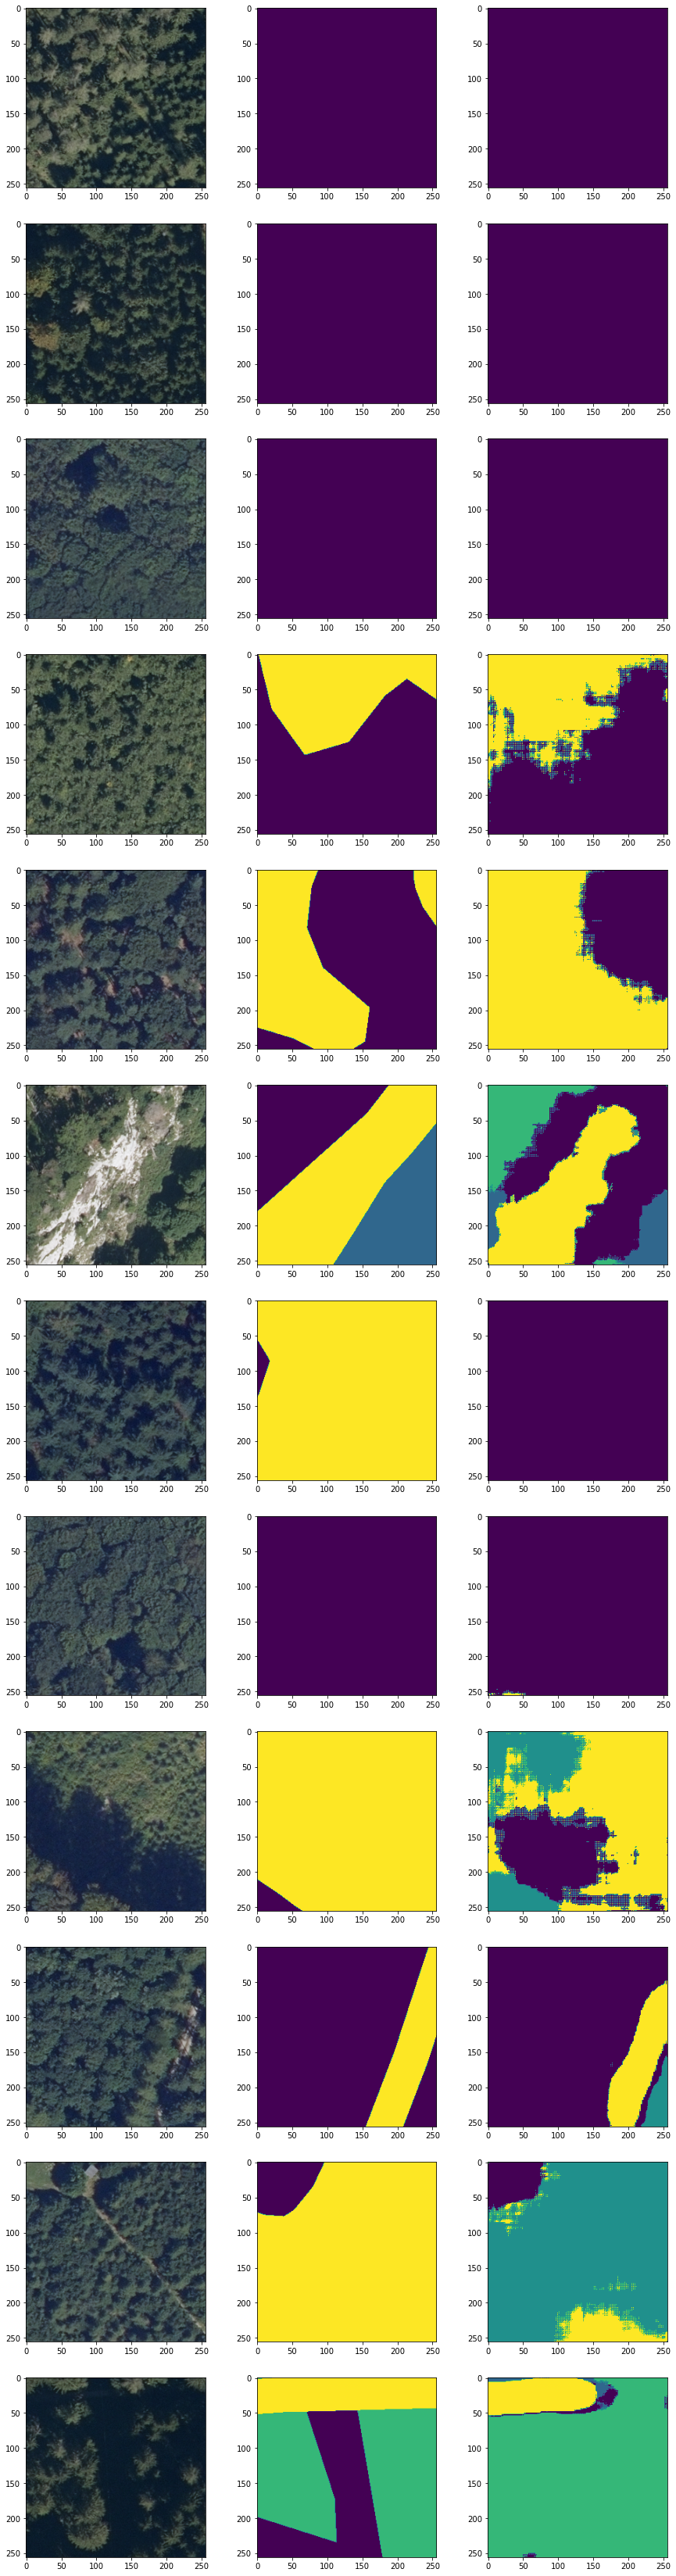

In [33]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [24]:
# save using pickle
#torch.save(unet,Path('model/unet_typ.pkl'))

# save 
torch.save(unet.state_dict(), SAVE_PATH)